In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim
from gensim import corpora
from gensim.utils import smart_open, simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn import cross_validation
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm, tqdm_notebook, tnrange
from sklearn.externals import joblib

In [2]:
train = pd.read_csv("../data/processed/comedy_comparisons.train")
test = pd.read_csv("../data/processed/comedy_comparisons.test")

In [3]:
def feature_sum_score(dataset_df):
    """
    This functions creates a score for each video which is the sum(better)-sum(worse)
    :param dataset_df: The dataset panda dataframe
    :return: Normalized series with the final score [-1..1] and the video_id's as index
    """
    better1 = dataset_df[dataset_df.funnier == 'left'].video_id1.sort_index().value_counts()
    better2 = dataset_df[dataset_df.funnier == 'right'].video_id2.sort_index().value_counts()
    better = better1.add(better2, fill_value=0).sort_index()
    worse1 = dataset_df[dataset_df.funnier == 'right'].video_id1.sort_index().value_counts()
    worse2 = dataset_df[dataset_df.funnier == 'left'].video_id2.sort_index().value_counts()
    worse = worse1.add(worse2, fill_value=0).sort_index()
    score = better.subtract(worse, fill_value=0).sort_index()
    max_score = score.abs().max()
    assert max_score != 0
    norm_score = score / max_score

    return norm_score

In [4]:
score_train = feature_sum_score(train)
score_test = feature_sum_score(test)

In [5]:
def get_corpus(df, dictionary, pbar=None):
    corpus = []
    df1 = {}
    for i, row in enumerate(df.itertuples()):
        curbow = dictionary.doc2bow(tokenize(row.textDisplay))
        corpus.append(curbow)
        if not pbar is None:
            pbar.update(1)
    #corpus['score'] = get_label(df, score, dictionary)
    return corpus

In [6]:
def get_label(df, score, dictionary):
    label = []
    for i, row in enumerate(df.itertuples()):
        if row.videoId in score:
            label.append(score[row.videoId])
        else:
            label.append(0)
    return label

In [7]:
data = pd.read_csv("../data/processed/train_dataset_with_lang_feature.csv")
data_en = data[data.language == 'en']
len(data_en)
data_en.head(10)

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3,4,5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,videoId,textDisplay,isReplyTo,canReply,totalReplyCount,kind,etag,id,authorChannelId,authorDisplayName,likeCount,publishedAt,updatedAt,viewerRating,language
0,0,sNabaB-eb3Y,They should made this as a double prank.. when...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/_aVRgxW14TFYS3sZy...",z23vvfnwmozww3ukvacdp433u2l5tjjzue32obodyxlw03...,{'value': 'UCDjudKsbl2T2KeanD-nrKXw'},Grise Blacolar,0,2013-05-15T16:41:33.000Z,2013-05-15T16:41:33.000Z,none,en
1,1,sNabaB-eb3Y,People are friendlier here than in other state...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/AOKhrA3U9J8iGUkun...",z22uxrrpaxiuyj5ri04t1aokg2ftoiu5vmacden0g5hzbk...,{'value': 'UCLBkXylBjiV0mN1dNhjIRbg'},alphacino,0,2012-11-04T16:32:45.000Z,2012-11-04T16:32:45.000Z,none,en
2,2,sNabaB-eb3Y,"I do live in Texas, how did you guess?!?!?!?!﻿",NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/gxMEOZY-YvfKneJSI...",z222innj3rmgxhlzp04t1aokg5c1sf24ibuxgughzte0rk...,{'value': 'UCXc-CFxsN7iXSL6X4-dDfYQ'},Lumilan,0,2012-11-04T16:21:29.000Z,2012-11-04T16:21:29.000Z,none,en
3,3,sNabaB-eb3Y,you mist live in texas. or maybe new york. you...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/K88xlkocl8TtWTMMt...",z22uxrrpaxiuyj5ri04t1aokgvgnbgrn4ewpkvjulgacrk...,{'value': 'UCLBkXylBjiV0mN1dNhjIRbg'},alphacino,0,2012-11-04T13:43:51.000Z,2012-11-04T13:43:51.000Z,none,en
4,4,sNabaB-eb3Y,They should have just opened the door with the...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/3NozddevGyZcalCaO...",z23tdtdihp3sz3emtacdp43afln2va1zwj4c2wnmljxw03...,{'value': 'UCY8-Q3GTP-a4yZ99GpG4Qww'},PandaMagicFTW,0,2012-10-02T21:35:52.000Z,2012-10-02T21:35:52.000Z,none,en
5,5,sNabaB-eb3Y,i love the music on JFL﻿,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/IRtPfKJcI4PawitZJ...",z23nebibyze2cb3pn04t1aokgkzznfqtt5wqaf5ebm3nbk...,{'value': 'UCXX6ufMotDsRRMj_1BiBk_w'},kimmyw010,0,2012-08-25T04:50:19.000Z,2012-08-25T04:50:19.000Z,none,en
6,6,sNabaB-eb3Y,It has 6 human power﻿,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/mi6gcIdUHEWkn0TKZ...",z23pzpz5vvmrjji0facdp4350cxxomrhh0vdeykuf4tw03...,{'value': 'UCbigvKFMTwsUX1FBhvYY6Tg'},SlickR12345,0,2012-06-26T12:59:15.000Z,2012-06-26T12:59:15.000Z,none,en
7,7,sNabaB-eb3Y,JustForLaughs is like an institution. Loads of...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/d1OXVB16zaiNit0kA...",z22yjr1grzrdeviap04t1aokgb1oyubgsfvzaxkrilrgbk...,{'value': 'UCS3Ri5tvGweVXwzUDGd-8RQ'},TheCulturalBomb,0,2012-06-20T02:17:52.000Z,2012-06-20T02:17:52.000Z,none,en
8,8,sNabaB-eb3Y,thumbs up if you saw the lauriel and hardy pos...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/vqHiKYG7jh576wOsi...",z224tfyjmkrjhffqm04t1aokgr10lkpvdkr5hv23chkebk...,{'value': 'UCih6jccG8q_rVCkqRcm3avQ'},MiguelBug,0,2012-05-16T13:22:37.000Z,2012-05-16T13:22:37.000Z,none,en
9,9,sNabaB-eb3Y,look at the shape of the key @1:11....lol lol ...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/xzPbrBd0AJEttdE_c...",z23qjnzo2xz0ujr4a04t1aokggyigqzp4h4hecowxdz2rk...,{'value': 'UCCWyqVEPJS3v53ggTYfRGNA'},varkyjas10,0,2012-03-27T10:05:55.000Z,2012-03-27T10:05:55.000Z,none,en


In [8]:
data_test = pd.read_csv("../data/processed/test_dataset_with_lang_feature.csv")
data_test_en = data_test[data_test.language == 'en']
len(data_test_en)

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3,4,5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2312215

In [9]:
seed = 85
dat = data.sample(10000, random_state=seed)
dat_test = data_test.sample(1000, random_state=seed)
all_data = pd.concat([dat, dat_test])
len(all_data)

11000

In [9]:
id2word = gensim.corpora.Dictionary.load('../data/processed/youtube_comments.dict')

In [10]:
def tokenize(text):
    ret = []
    i = 0
    token = ""
    try:
        for token in simple_preprocess(text):
            if token not in STOPWORDS:
                ret.append(token)
            i = i + 1
        #ret = [token for token in simple_preprocess(text) if token not in STOPWORDS]
    except Exception as e:
        pass
        # print("ERROR in line: ", i)
        # print("Cur token", token)
        # print("ERROR: ", e)
    return ret
        

In [11]:
dat = data
dat_test = data_test
all_data = pd.concat([data, data_test])

In [18]:
pbar = tqdm_notebook(range(len(all_data)), desc="Creating corpus")
corpus = get_corpus(all_data, id2word, pbar)
scipy_corpus = gensim.matutils.corpus2csc(corpus)
label = get_label(dat, score_train, id2word)

In [19]:
corpora.MmCorpus.serialize('../data/processed/fullcorpus.mm', corpus)

In [10]:
corpus = corpora.MmCorpus('../data/processed/fullcorpus.mm')


In [11]:
scipy_corpus = gensim.matutils.corpus2csc(corpus)


In [12]:
label = get_label(data, score_train, id2word)

In [15]:
training_size = len(data)
scipy_train = scipy_corpus[:, 0:training_size]

In [17]:
# Create linear regression object
regr = linear_model.LinearRegression(n_jobs=-1)

# Train the model using the training sets
regr.fit(scipy_train.transpose(), label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [19]:
joblib.dump(regr, '../models/linear_regression.pkl')

['../models/linear_regression.pkl', '../models/linear_regression.pkl_01.npy']

In [13]:
regr = joblib.load('../models/linear_regression.pkl')

In [14]:
scipy_test = scipy_corpus[:, training_size:]
label_test = get_label(data_test, score_test, id2word)

NameError: name 'training_size' is not defined

In [23]:
print('Variance score: %.2f' % regr.score(scipy_train.transpose(), label))

Variance score: 0.27


In [24]:
y_true = label_test
y_pred = regr.predict(scipy_test.transpose())
r2 = r2_score(y_true, y_pred)
mean_sq_error = mean_squared_error(y_true, y_pred)
r2, mean_sq_error

(-0.31908803103436467, 0.00041419454445549246)

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


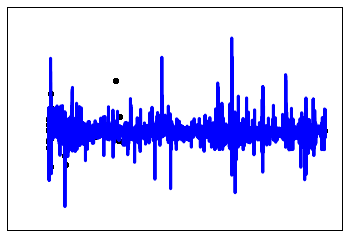

In [25]:
plt.scatter(range(len(label_test)), label_test,  color='black')
plt.plot(range(len(label_test)), regr.predict(scipy_test.transpose()), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
# cross validation in the training set
#array_train = scipy_train.toarray()
#X = array_train.transpose()
X = scipy_train.transpose()
Y = label
num_folds = 100
num_instances = len(array_train)

In [ ]:
seed = 85
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = linear_model.LinearRegression()
scoring = 'mean_squared_error'

In [ ]:
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)

6645243